# Solver using IP webCam
Yuqing Yang (*Github ID: mydmdm*)

## Introduction
This notebook will give an demo of how to recognize an puzzle from the Camera of an Android device, solve it in the python script and then feedback the result to the picture. Actually there are multiple operations to accomplish this task, which will be covered in this notebook includes
+ read camera image (video) from an Android device by IP webCam 
+ segment the puzzle from the picture (making use of image processing algorithms in OpenCV)
+ digits recogniztion
+ solve puzzle using backtrack algorithm
+ write the results back to original picture

We will start from a pre-stored puzzle picture, and then connected to the camera. 

### Source code and Reference
You may get the source code from https://github.com/mydmdm/sudoku

This notebook is partly reference the resources from the website
- https://caphuuquan.blogspot.com/2017/04/building-simple-sudoku-solver-from.html
- http://www.shogun-toolbox.org/static/notebook/current/Sudoku_recognizer.html

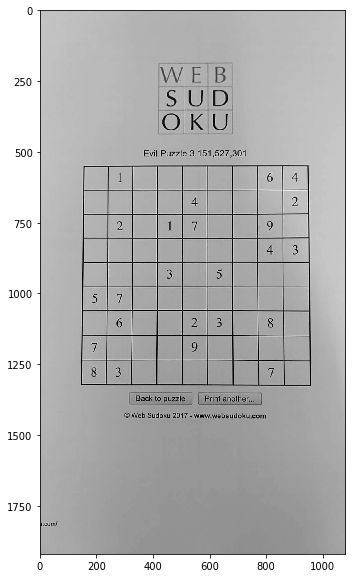

In [46]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# url is what shown in the IP web camera application
url='http://211.192.192.98:8080/shot.jpg'

# here is the example picture 
img = cv2.imread('example.jpg')
# BGR format to gray
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

figsize = (15,10)
plt.figure(figsize=figsize)
_ = plt.imshow(img_gray)

## Segment the puzzle
The first task is to segment the puzzle from the picture. The basic assumption is that the puzzle is the biggest region with convex shape in the picture. 

Firstly, an *adaptativeThreshold* method is used to extract the edge of the image (for each pixel in the image take the average value of the surrounding area). This function accepts a gray scale image, with the function cvtColor we change the color space (from RGB to gray scale). 

Then the connected contours in the image are found by the function *findContours*. After that, we filter out the contour with four sides and *isContourConvex*. 

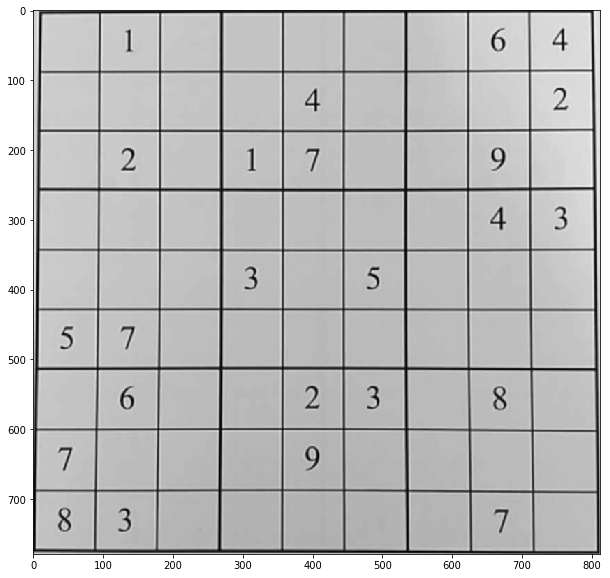

In [47]:
def getApproximateConvexArea(contour):
    appx = cv2.approxPolyDP(contour, 4, True)
    if len(appx)!=4 or not cv2.isContourConvex(appx):
        return 0
    return cv2.contourArea(appx)

def getContourImage(img, contour):
    x,y,w,h = cv2.boundingRect(contour)
    crop = img[y:y+h,x:x+w]
    return crop

def getBiggestConvexContour(img):
    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    area = [getApproximateConvexArea(c) for c in contours]
    k = np.argmax(np.array(area))
    return contours[k]

def segmentPuzzle(img_gray):
    # smooth the picture (low-pass filtered)
    img_gray = cv2.blur(img_gray, (3,3))
    
    # get the biggest convex contour and crop it out
    thr = cv2.adaptiveThreshold(img_gray,255,1,1,15,15)    
    contour = getBiggestConvexContour(thr)
    return getContourImage(img_gray, contour)

img_puzzle = segmentPuzzle(img_gray)
plt.figure(figsize=figsize)
_ = plt.imshow(img_puzzle)

## Split to digits
After getting the whole puzzle, the next step is to split it into pieces of digits. Of course, we can detect the lines and then split up the image based on them. However, to simpilify, one can split by equally slice the x / y axis into 9 pieces. If some of the digits are too close to the splitting boundaries, we may adjust them later. 

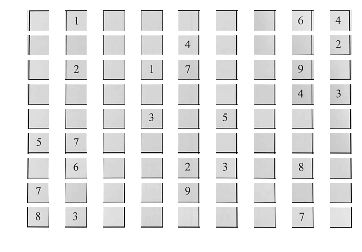

In [118]:
def getDigitImages(img):
    x = [int(k*img.shape[0]/9) for k in range(10)]
    y = [int(k*img.shape[1]/9) for k in range(10)]
    out = [[img[x[i]:x[i+1],y[j]:y[j+1]] for j in range(9)] for i in range(9)]
    return out

img_digits = getDigitImages(img_puzzle)
plt.figure(2)
for i in list(range(9)):
    for j in list(range(9)):
        plt.subplot(9,9,9*i+j+1)
        plt.imshow(img_digits[i][j])
        plt.axis('off')

## Recognize digits
Now we need to use the pretraind model for digits recognition (trained by MNIST dataset). For simplify, I use a Neural network without convolutional layers model.

Firstly, let's train a model with the MNIST data. After training, we can save the model and next time we can use it directly.

In [121]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
 
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
 
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
 
# 7. Define model architecture
model = Sequential()
 
#model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
#model.add(Convolution2D(32, 3, 3, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))
 
model.add(Flatten(input_shape=(1,28,28)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)
model.save('nn_mnist.h5')

C:\Users\yuqyang\AppData\Local\Programs\Python\Python35\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
60000/60000 [==============================] - 6s - loss: 0.3894 - acc: 0.8840     
Epoch 2/10
60000/60000 [==============================] - 6s - loss: 0.2225 - acc: 0.9338     
Epoch 3/10
60000/60000 [==============================] - 6s - loss: 0.1829 - acc: 0.9446     
Epoch 4/10
60000/60000 [==============================] - 6s - loss: 0.1623 - acc: 0.9504     
Epoch 5/10
60000/60000 [==============================] - 6s - loss: 0.1499 - acc: 0.9544     
Epoch 6/10
60000/60000 [==============================] - 6s - loss: 0.1385 - acc: 0.9570     
Epoch 7/10
60000/60000 [==============================] - 7s - loss: 0.1292 - acc: 0.9604     
Epoch 8/10
60000/60000 [==============================] - 7s - loss: 0.1246 - acc: 0.9608     
Epoch 9/10
60000/60000 [==============================] - 9s - loss: 0.1179 - acc: 0.9631     - 
Epoch 10/10
60000/60000 [==============================] - 8s - loss: 0.1133 - acc: 0.9637     


In [ ]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Replace the URL with your own IPwebcam shot.jpg IP:port
# url='http://211.192.192.98:8080/shot.jpg'
url='file:///C:/Users/yuqyang/Desktop/example.JPG'

url='file:///C:/Users/yuqyang/Downloads/1479504130.jpg'

#cv2.namedWindow("Solver")

while True:
    # Use urllib to get the image and convert into a cv2 usable format
    imgResp=urllib.request.urlopen(url)
    imgNp=np.array(bytearray(imgResp.read()),dtype=np.uint8)
    img=cv2.imdecode(imgNp,flags=cv2.IMREAD_GRAYSCALE )

    print(img.shape)
    while min(img.shape[0:2]) > 1000:
        img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)

    # put the image on screen

    #To give the processor some less stress
    #time.sleep(0.1) 

    # extract digits
    edges = cv2.Canny(img, 30, 90)
    lines = cv2.HoughLines(edges, 2, np.pi /180, 300, 0, 0)

    _, contours, hierarchy = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    img = cv2.drawContours(img, contours, -1, (255,0,0))

    #cv2.imshow('Solver',img)
    #cv2.waitKey()
    plt.imshow(img, cmap='gray')
    plt.show()
    
    break
    if 0xFF == ord('q'):
        break

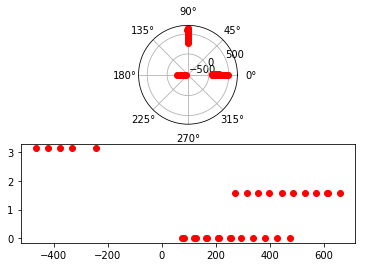

In [12]:
ln = np.squeeze(lines)
plt.figure(1)
ax = plt.subplot(211, projection='polar')
ax.plot(ln[:,1], ln[:,0], 'ro')
ax2 = plt.subplot(212)
ax2.plot(ln[:,0], ln[:,1], 'ro')